In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.optimize
import pandas.io.sql as psql
import pandas as pd
import sys
sys.path.insert(0,'C:\Users\Sean Violante\Documents\Projects\lendico\lib')
import dwh
from __future__ import division

In [2]:
%matplotlib qt

In [3]:
conn = dwh.get_DWH()

In [4]:
excluded_loans=(3,4,6,8,11,14,526,528,558,630,557,556,555,553,552,554,578,579,580,603,596,611,642)
print(" hello {}".format(excluded_loans))

 hello (3, 4, 6, 8, 11, 14, 526, 528, 558, 630, 557, 556, 555, 553, 552, 554, 578, 579, 580, 603, 596, 611, 642)


In [23]:
excluded_loans="(-1)"

In [71]:
payment_plans_combined_sql="""SELECT pp.dwh_country_id, pp.fk_loan, pp.fk_loan_request,l.loan_nr as loan_request_nr, 
        pp.fk_user_investor, pp.fk_user_borrower, pp.country_name, 
        pp.nominal_interest_percentage, pp.promo_interest_percentage, pp.has_promo_flag, 
        pp.is_repaid_flag, 
        pp.payout_date, pp.interval, pp.interval_payback_date, pp.next_interval_payback_date, 
        pp.loan_coverage, 
    
        pp.payment_amount_borrower,
        sum(pp.payment_amount_borrower) OVER wind as payment_amount_borrower_cum,
        
        pp.principal_amount_borrower, 
        sum(pp.principal_amount_borrower) OVER wind as principal_amount_borrower_cum,
        
        pp.interest_amount_borrower,
        sum(pp.interest_amount_borrower) OVER wind as interest_amount_borrower_cum,
        
        pp.initial_principal_amount_borrower, 
        pp.residual_interest_amount_borrower, pp.residual_principal_amount_borrower, 
        
        pp.calc_service_fee, 
        
        pp.payment_amount_investor, 
        sum(pp.payment_amount_investor) OVER wind as payment_amount_investor_cum,
        
        pp.principal_amount_investor, 
        sum(pp.principal_amount_investor) OVER wind as principal_amount_investor_cum,
        
        pp.interest_amount_investor, 
        sum(pp.interest_amount_investor) OVER wind as interest_amount_investor_cum,
        
        pp.initial_principal_amount_investor, pp.sum_interval_interest_amount_investor, 
        pp.residual_interest_amount_investor, pp.residual_principal_amount_investor
    
        
        FROM base.loan_payment_plan_combined_item pp
        join base.loan l on (pp.dwh_country_id=l.dwh_country_id and pp.fk_loan=l.id_loan )
        join base.loan_funding lf on (pp.dwh_country_id=lf.dwh_country_id and pp.fk_loan=lf.fk_loan and pp.fk_user_investor=lf.fk_user)
        where pp.dwh_country_id=1 and 
        l.state!='canceled' 
        and l.id_loan not in {} and 
        l.originated_since is not null and
        lf.state='funded'
        WINDOW wind as (PARTITION BY pp.dwh_country_id, pp.fk_loan, pp.fk_user_investor order by interval)
        """.format(excluded_loans)

# load german combined payment plan up to system date (very large), removing cancelled/non funded loans and loans created by lendico 'borrowers'

In [26]:
payment_plans_sql="""select 
pp.dwh_country_id, pp.fk_loan_payment_plan, pp.fk_user, pp.fk_loan_request, pp.fk_loan, 
pp.country_name, pp.currency_code, pp.loan_request_creation_date, 
interval, payment_amount, pp.interest_amount, pp.principal_amount, interval_payback_date, next_interval_payback_date, 
initial_principal_amount, sum_interval_interest_amount, residual_interest_amount, residual_principal_amount
from base.loan_payment_plan_item pp
join base.loan l on          (pp.dwh_country_id=l.dwh_country_id and pp.fk_loan=l.id_loan )
where pp.dwh_country_id=1 and l.state!='canceled'  and l.originated_since is not null
and l.id_loan not in {}""".format(excluded_loans)
# load german borrower payment plan , removing cancelled, not yet originated  loans and loans created by lendico 'borrowers'


In [374]:
loans_sql="""select l.*, gblrc.credit_agency_score, gblrc.pd, gblrc.pd_original, gblrc.lgd, gblrc.in_arrears_since, 
lp.payback_day,lp.payout_date, lp.state as payback_state, lp.auto_in_arrears_since, lp.in_arrears_since in_arrears_since_man
from base.loan l
join il.global_borrower_loan_requests_cohort gblrc
on (l.dwh_country_id=gblrc.dwh_country_id and l.loan_nr=gblrc.loan_request_nr)

join base.loan_payback lp
on (l.dwh_country_id=lp.dwh_country_id and l.id_loan=lp.fk_loan)
where 
    l.dwh_country_id=1 and 
    l.state!='canceled' and 
    id_loan not in {} and 
    originated_since is not null""".format(excluded_loans)


# load loans removing cancelled, not yet originated  loans and loans created by lendico 'borrowers'

In [105]:
actual_payments_combined_sql= """
with 
actual_payments as (select 
dp.dwh_country_id, dp.fk_user as fk_user_borrower, dp.fk_loan, dp.loan_request_nr
 ,dp.iso_date 
 ,dp.expected_amount_cum, dp.actual_amount_cum, in_arrears_flag, dp.in_arrears_since
 ,in_arrears_since_days
 -- expected/actual payment over month (by taking diff of cumsum)
,dp.expected_amount_cum - lag(expected_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan  order by dp.iso_date)  expected_amount_month
,dp.actual_amount_cum - lag(actual_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan order by iso_date)
 actual_amount_month
 from base.de_payments dp
join base.loan_payback lp on (lp.dwh_country_id=dp.dwh_country_id and lp.fk_loan=dp.fk_loan) 
where dp.iso_date=(date_trunc('MONTH', dp.iso_date) + INTERVAL '1 MONTH - 1 day')::date
and (lp.state!='payback_complete' or lp.in_arrears_since is not null or dp.iso_date <=lp.last_payment_date)
and dp.fk_loan not in {}
) ,
-- select End of month, excluding those that have now paid back ( apart from those that were paid back by lendico)
-- find corresponding payment plan item.
-- we find the maximum payment plan interval that has cum_payment<= actual_cum 
-- could also use distinct on?
-- match only actual payments that have happened after plan date
-- problem is overpayments [ ie where payment plan has not been updated with extra payment.. because 
actual_payments_cum as (
select 
ap.dwh_country_id, ap.fk_loan, 
-- dp.iso_date as date,min(pp.interval) as interval, min(interval_payback_date) interval_payback_date--, dp.actual_amount_cum, pp.payment_amount_cum'
ap.iso_date,max(pp.interval) as interval

from actual_payments ap

join 
(select dwh_country_id, fk_loan, interval, interval_payback_date, sum(payment_amount) 
	OVER (partition by dwh_country_id,fk_loan order by interval) payment_amount_cum  
	from base.loan_payment_plan_item  where interval_payback_date<=current_date) pp
on 
 (ap.dwh_country_id=pp.dwh_country_id and
 ap.fk_loan=pp.fk_loan and -- we need this to exclude extra payments that have not been added to payment plan
 ap.iso_date>=pp.interval_payback_date and
 ap.actual_amount_cum>=pp.payment_amount_cum )
 

group by ap.dwh_country_id, ap.fk_loan,  ap.iso_date 
--order by date, interval

),


 paymentplan as
(
        SELECT pp.dwh_country_id, pp.fk_loan, pp.fk_loan_request,  l.loan_nr as loan_request_nr,
        pp.fk_user_investor, pp.fk_user_borrower, pp.country_name, pp.nominal_interest_percentage, pp.promo_interest_percentage, pp.has_promo_flag, 
        pp.is_repaid_flag, pp.payout_date, 
		pp.interval, pp.interval_payback_date, pp.next_interval_payback_date, pp.loan_coverage, 
        pp.payment_amount_borrower, pp.principal_amount_borrower, pp.interest_amount_borrower, 
		pp.initial_principal_amount_borrower, pp.sum_interval_interest_amount_borrower, 
        pp.residual_interest_amount_borrower, pp.residual_principal_amount_borrower, pp.payment_amount_promo, pp.principal_amount_promo, pp.interest_amount_promo, pp.initial_principal_amount_promo, 
        pp.sum_interval_interest_amount_promo, pp.residual_interest_amount_promo, pp.residual_principal_amount_promo, pp.calc_service_fee,
        pp.payment_amount_investor, 
 
		pp.principal_amount_investor, pp.interest_amount_investor, 
		pp.initial_principal_amount_investor, pp.sum_interval_interest_amount_investor, 
        pp.residual_interest_amount_investor, pp.residual_principal_amount_investor
		, sum(coalesce(payment_amount_investor,0) ) OVER W::float as payment_amount_investor_cum
		, sum(coalesce(pp.interest_amount_investor,0) ) OVER W::float as interest_amount_investor_cum
		, sum(coalesce(pp.principal_amount_investor,0) ) OVER W::float as principal_amount_investor_cum
        FROM base.loan_payment_plan_combined_item pp

 join   base.loan l    
 on     l.id_loan=pp.fk_loan and l.dwh_country_id=pp.dwh_country_id  
 join  base.loan_funding lf   on   
 (pp.dwh_country_id=lf.dwh_country_id and pp.fk_loan=lf.fk_loan and pp.fk_user_investor=lf.fk_user)
where pp.dwh_country_id=1 and  pp.interval_payback_date<=current_date and  lf.state='funded' and l.state!='canceled'
WINDOW W as (partition by pp.dwh_country_id, pp.fk_loan, pp.fk_user_investor ORDER BY pp.interval_payback_date)
)

select 

 ap.dwh_country_id as dwh_country_id
 , ap.fk_user_borrower
 ,lf.fk_user as fk_user_investor
 , ap.fk_loan as fk_loan
 , ap.loan_request_nr
 , ap.iso_date,
 
 
pp.nominal_interest_percentage, pp.promo_interest_percentage, pp.has_promo_flag, 
pp.is_repaid_flag, pp.payout_date, pp.interval, pp.interval_payback_date, pp.next_interval_payback_date, pp.loan_coverage, 
pp.payment_amount_borrower, pp.principal_amount_borrower, pp.interest_amount_borrower, pp.initial_principal_amount_borrower, pp.sum_interval_interest_amount_borrower, 
pp.residual_interest_amount_borrower, pp.residual_principal_amount_borrower, pp.calc_service_fee,

pp.payment_amount_investor, pp.payment_amount_investor_cum,
pp.payment_amount_investor_cum - lag(pp.payment_amount_investor_cum,1,0.0::float) over W payment_amount_investor_month,
pp.principal_amount_investor, pp.interest_amount_investor, pp.sum_interval_interest_amount_investor, 
pp.interest_amount_investor_cum,
pp.residual_interest_amount_investor,
pp.principal_amount_investor_cum,
pp.initial_principal_amount_investor, 
coalesce (pp.residual_principal_amount_investor, lf.amount) as residual_principal_amount_investor

,expected_amount_month, expected_amount_cum
,actual_amount_month, actual_amount_cum
, in_arrears_flag, in_arrears_since
 ,in_arrears_since_days  


from actual_payments ap
left join actual_payments_cum ap_cum 
   on( 
  ap.dwh_country_id=ap_cum.dwh_country_id and 
  ap.fk_loan=ap_cum.fk_loan and 
  ap.iso_date=ap_cum.iso_date
   )

join base.loan_funding lf on (
 ap.dwh_country_id=lf.dwh_country_id and
 ap.fk_loan=lf.fk_loan

)
   
left join paymentplan pp on (
    pp.dwh_country_id=ap.dwh_country_id and 
    pp.fk_user_investor = lf.fk_user and
    pp.fk_loan=ap.fk_loan and 
    ap_cum.interval=pp.interval) 
where  ap.dwh_country_id=1 and ap.iso_date <=current_date and lf.state='funded'
WINDOW W as( partition by ap.dwh_country_id, ap.fk_loan, pp.fk_user_investor  order by ap.iso_date)
order by dwh_country_id,fk_loan,iso_date 
;""".format(excluded_loans)


In [78]:
actual_payments_sql= """
with 
actual_payments as (select 
dp.dwh_country_id, dp.fk_user as fk_user_borrower, dp.fk_loan, dp.loan_request_nr
 ,dp.iso_date 
 ,dp.expected_amount_cum, dp.actual_amount_cum, in_arrears_flag, dp.in_arrears_since
 ,in_arrears_since_days
-- expected/actual payment over month (by taking diff of cumsum)
,dp.expected_amount_cum - lag(expected_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan  order by dp.iso_date)  expected_amount_month
,dp.actual_amount_cum - lag(actual_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan order by iso_date)
 actual_amount_month
 from base.de_payments dp
 join base.loan_payback lp on (lp.dwh_country_id=dp.dwh_country_id and lp.fk_loan=dp.fk_loan) 
where dp.iso_date=(date_trunc('MONTH', dp.iso_date) + INTERVAL '1 MONTH - 1 day')::date
and (lp.state!='payback_complete' or lp.in_arrears_since is not null or dp.iso_date <=lp.last_payment_date)
and dp.fk_loan not in {0}
) ,
-- select End of month, excluding those that have now paid back ( apart from those that were paid back by lendico)
-- find corresponding payment plan item.
-- we find the maximum payment plan interval that has cum_payment<= actual_cum 
-- could also use distinct on?
-- match only actual payments that have happened after plan date
-- problem is overpayments [ ie where payment plan has not been updated with extra payment.. because 
actual_payments_cum as (
select 
ap.dwh_country_id, ap.fk_loan, 
-- dp.iso_date as date,min(pp.interval) as interval, min(interval_payback_date) interval_payback_date--, dp.actual_amount_cum, pp.payment_amount_cum'
ap.iso_date,max(pp.interval) as interval

from actual_payments ap

join 
(select dwh_country_id, fk_loan, interval, interval_payback_date, sum(payment_amount) \
    OVER (partition by dwh_country_id,fk_loan order by interval) payment_amount_cum  
    from base.loan_payment_plan_item where interval_payback_date<=current_date) pp
on 
 (ap.dwh_country_id=pp.dwh_country_id and
 ap.fk_loan=pp.fk_loan and -- we need this to exclude extra payments that have not been added to payment plan
 ap.iso_date>=pp.interval_payback_date and 
 ap.actual_amount_cum>=pp.payment_amount_cum )
 
group by ap.dwh_country_id, ap.fk_loan,  ap.iso_date 
--order by date, interval

),


 paymentplan as
(

	SELECT pp.dwh_country_id, pp.fk_user, pp.fk_loan_request,pp.fk_loan, l.loan_nr
	,pp.country_name, interval, payment_amount, pp.interest_amount
	,pp.principal_amount,interval_payback_date,next_interval_payback_date,
	initial_principal_amount, sum_interval_interest_amount,
	residual_interest_amount,residual_principal_amount
	, sum(coalesce(payment_amount,0) )  OVER W::float as payment_amount_cum
	, sum(coalesce(pp.interest_amount,0) ) OVER W::float as interest_amount_cum
	, sum(coalesce(pp.principal_amount,0) ) OVER W::float as principal_amount_cum

 FROM base.loan_payment_plan_item pp 
        

 join   base.loan l    
 on     l.id_loan=pp.fk_loan and l.dwh_country_id=pp.dwh_country_id  
 where  pp.dwh_country_id=1 and pp.interval_payback_date<=current_date
WINDOW W as (partition by pp.dwh_country_id, pp.fk_loan ORDER BY pp.interval_payback_date)
)

select 

 
 ap.dwh_country_id as dwh_country_id
 , ap.fk_user_borrower
 , ap.fk_loan as fk_loan
 , ap.loan_request_nr as loan_nr --changed from pp.loan_nr
 , ap.iso_date
 , pp.interval
 , pp.interval_payback_date
,pp.payment_amount, pp.payment_amount_cum,

pp.principal_amount, pp.interest_amount, pp.sum_interval_interest_amount, 
pp.interest_amount_cum,
pp.residual_interest_amount,
 pp.principal_amount_cum,
 pp.initial_principal_amount, 
coalesce (pp.residual_principal_amount, l.principal_amount) as residual_principal_amount

,expected_amount_month, expected_amount_cum
,actual_amount_month, actual_amount_cum
, in_arrears_flag, in_arrears_since
 ,in_arrears_since_days  



from actual_payments ap
left join actual_payments_cum ap_cum 
   on( 
  ap.dwh_country_id=ap_cum.dwh_country_id and 
  ap.fk_loan=ap_cum.fk_loan and 
  ap.iso_date=ap_cum.iso_date
   )
  
left join paymentplan pp
 
on (pp.dwh_country_id=ap.dwh_country_id and 
        pp.fk_loan=ap.fk_loan and 
        ap_cum.interval=pp.interval)
join base.loan l 
on (ap.dwh_country_id=l.dwh_country_id and ap.fk_loan=l.id_loan)
where  ap.dwh_country_id=1 and ap.iso_date <=current_date and  ap.fk_loan not in {0} 

order by dwh_country_id,fk_loan,iso_date ;
""".format(excluded_loans)


In [29]:
loan_fundings_sql="""select * from base.loan_funding where dwh_country_id=1 
and fk_loan not in {} and state='funded'""".format(excluded_loans)

In [ ]:
%time loans=psql.read_sql(loans_sql,conn)

In [61]:
%time loan_fundings=psql.read_sql(loan_fundings_sql,conn)

Wall time: 26 s


In [62]:
%time payment_plans=psql.read_sql(payment_plans_sql,conn)

Wall time: 38.3 s


In [72]:
%time payment_plans_combined=psql.read_sql(payment_plans_combined_sql,conn)

Wall time: 19min 59s


In [80]:
%time actual_payments=psql.read_sql(actual_payments_sql,conn)

Wall time: 13.1 s


In [106]:
%time actual_payments_combined=psql.read_sql(actual_payments_combined_sql,conn)

Wall time: 2min 28s


In [261]:
loans['rating_base']=loans.rating.str[0]
loans['originated_since_date']=np.array(loans.originated_since,'datetime64[D]')
loans['rating_switch']=1 + \
    (loans['originated_since_date']>np.datetime64('2014-06-30')) + \
    (loans['originated_since_date']>np.datetime64('2014-10-14'))

In [276]:
loans['originated_since_date_EOM']=loans['originated_since_date']+np.array(30-loans.payback_day,'timedelta64[D]')

In [277]:
loan_fundings1=loan_fundings.merge(loans[['id_loan','originated_since_date','originated_since_date_EOM','payback_day','principal_amount']],left_on=['fk_loan'],right_on=['id_loan'])

In [266]:
loan_fundings1['loan_coverage1']=loan_fundings1.amount/loan_fundings1.principal_amount*100

In [146]:
z1=pd.DataFrame(actual_payments.set_index(['iso_date','fk_loan'])[['in_arrears_since', 'in_arrears_since_days']])
z1['bucket']=np.ceil(z1.in_arrears_since_days/30)
a1=z1.bucket.unstack()

a2=a1.shift(-1, freq='M')
a3=a1.shift(-2, freq='M')
a4=a1.shift(-3, freq='M')
a5=a1.shift(-4, freq='M')
a6=a1.shift(-5, freq='M')
a7=a1.shift(-6, freq='M')


z1['in_arrears_since_1M']=a2.stack()
z1['in_arrears_since_2M']=a3.stack()
z1['in_arrears_since_3M']=a4.stack()
z1['in_arrears_since_4M']=a5.stack()
z1['in_arrears_since_5M']=a6.stack()
z1['in_arrears_since_6M']=a7.stack()



In [ ]:
# trying to detemine stability 

In [148]:
z2=z1.fillna(0)

In [150]:
z3=z2.groupby(['bucket','in_arrears_since_1M']).size()

In [134]:
z1=actual_payments_combined[actual_payments_combined.iso_date==datetime.date(2015,4,30)].residual_principal_amount_investor

In [137]:
(z1.isnull()).sum()


0

In [359]:
def days360_tup(diff):
    # not actually 30360 as in bond basis. 
    # note february -> 30 so longer ( and 31 months get shortened)
    x=None
    try:
        x=(diff[1].year-diff[0].year)*360+(diff[1].month-diff[0].month)*30+min((diff[1].day-diff[0].day),30)
    except AttributeError:
        pass
    return x
       
def days360(start,end):
    diffs=zip(start,end)
    
    return map(days360_tup, diffs)

def rebase(x):
    # we treat interval 0 as special ( can't default then)
    # might consider doing fractional amount
    # if first interval is zero, return x otherwise x-x[0]+1
    # different investors may or may not have zero ( if investment too loo <1 cent interest)
    min_interval=x.min()
    if min_interval!=0:
        min_interval-=1
    return x-min_interval

def calc_survival(pp):
    # outputs new dataframe
    ### CURRENTLY WRONG initial principal_amount is borrower not investor
    pp=pp.copy()
    pp['interval_rebased']=pp[['fk_loan','interval']].groupby('fk_loan').transform(rebase)
    
    pp['surv_month']=(1-pp.pd).pow(1/12.0)
    pp['survive'] =pp.surv_month.pow(pp.interval_rebased)
    pp['default'] =(pp.interval_rebased>0) * pp.surv_month.pow(pp.interval_rebased-1) * (1-pp.surv_month)
    pp['e_payment_amount']=pp.survive * pp.payment_amount
    pp['e_recovery']=pp.default * pp.recovery*pp.initial_principal_amount
    pp['e_tot']=pp.e_payment_amount + pp.e_recovery
    pp['e_tot_svc']=pp['e_tot']*(1-0.01)
    return pp

def calc_survival_investor(pp):
    # outputs new dataframe
    pp=pp.copy()
    pp['interval_rebased']=pp[['fk_loan','interval']].groupby(['fk_loan']).transform(rebase)
    
    pp['surv_month']=(1-pp.pd).pow(1/12.0)
    pp['survive'] =pp.surv_month.pow(pp.interval_rebased)
    pp['default'] =(pp.interval_rebased>0) * pp.surv_month.pow(pp.interval_rebased-1) * (1-pp.surv_month)
    pp['e_payment_amount_investor']=pp.survive * pp.payment_amount_investor
    pp['e_recovery']=pp.default * pp.recovery*pp.initial_principal_amount_investor
    pp['e_tot']=pp.e_payment_amount_investor + pp.e_recovery
    return pp



def make_pd_arrears( act_pay, loans, latest_date,arrears_dict):
    act_pay=act_pay[np.array(act_pay.iso_date,'datetime64[D]')==np.datetime64(latest_date,'D')].copy()
    act_pay['bucket']=np.ceil(act_pay.in_arrears_since_days_30360/30)*30
    act_pay['bucket_pd']=act_pay.bucket.map(arrears_dict)
    
    return loans.merge(act_pay[['fk_loan','in_arrears_since', 'in_arrears_since_days',\
                                'in_arrears_since_days_30360', 'bucket', 'bucket_pd']], \
                       left_on='id_loan',right_on='fk_loan',how='left')
    
def add_pd(pp, loans, use_in_arrears):
    """ add pd from loans, divide by 100, and create dupl pd_noarr """
    pp_pd=pp.merge(loans[['id_loan','pd','bucket_pd']],left_on='fk_loan',right_on='id_loan')
    pp_pd['pd']=pp_pd['pd']/100.0
    pp_pd['pd_noarr']=pp_pd['pd']
    if use_in_arrears:
        pp_pd.loc[pp_pd.bucket_pd.notnull(),'pd']=pp_pd.loc[pp_pd.bucket_pd.notnull(),'bucket_pd']
    return pp_pd                

def make_future_pd(payment_plans,loans, arrears_dict, use_in_arrears, EOM_date_str=None, latest_paid_interval=None):
    """ 
        select future payments ( after EOM_date_str)
        for each loan remove payment_plans where already paid
        if EOM_date_str is None use all data 
    """
    
    if EOM_date_str is not None:
        EOM_date=datetime.datetime.strptime(EOM_date_str,'%Y-%m-%d').date()
        fut=payment_plans[payment_plans.interval_payback_date > EOM_date ].merge(\
                        pd.DataFrame(latest_paid_interval),left_on=['fk_loan','fk_user_investor'],right_index=True,how='left')
        fut=fut[(fut.latest_paid_interval.isnull() )|(fut.interval>fut.latest_paid_interval)]
    else:
        fut=payment_plans.copy()
    # drop intervals already in actual???
    fut_pd=add_pd(fut, loans, use_in_arrears)
    fut_pd=calc_survival_investor(fut_pd)
    return fut_pd

def generate_cashflows_act_investor( actual,loan_funding, EOM_date_str):
    # take payments and add initial principal and remaining principal
    # the remaining principal is all that has to be paid back (including in arrears principals)
    EOM_date=datetime.datetime.strptime(EOM_date_str,'%Y-%m-%d').date()
    
    
    loans_orig=loan_funding.loc[loan_funding.originated_since_date<EOM_date,['fk_loan','fk_user','originated_since_date_EOM','amount']].copy()
    loans_orig.amount=-loans_orig.amount    
    loans_orig.rename(columns={'fk_loan':'id_loan', 'fk_user':'fk_user_investor','originated_since_date_EOM':'date' ,'amount':'payment'},inplace=True)
    
    act=actual.loc[actual.iso_date<=EOM_date,['fk_loan','iso_date','fk_user_investor','payment_amount_investor_month']].\
        rename(columns={'fk_loan':'id_loan','iso_date':'date',
                        'payment_amount_investor_month':'payment'})
    act.date=np.array(act.date,'datetime64[D]')
    residual=actual.loc[actual.iso_date==EOM_date,['fk_loan','fk_user_investor', 'residual_principal_amount_investor']].\
            rename(columns={'fk_loan':'id_loan','residual_principal_amount_investor':'payment'})
    residual['date']=np.datetime64(EOM_date,'D')
    
    cashflows=act.append([residual,loans_orig],ignore_index=True)
    cashflows['dcf']=(np.datetime64('2015-04-01','D')  -cashflows["date"].values)/np.timedelta64(1,'D')/365
    cashflows=cashflows.merge(loans[['id_loan','originated_since_date','rating_base','rating_switch','payback_state']],on='id_loan',how='left')
    return cashflows


def generate_cashflows_pp(pp,loan_fundings,loans, EOM_date_str=None):
    if EOM_date_str is None:
        EOM_date_str='2300-01-01'
    EOM_date=datetime.datetime.strptime(EOM_date_str,'%Y-%m-%d').date()
    # generate cashflows from plan for xirr ( by taking payment amount, loan funding and residual principal
    # exclude loans for which no plan yet or interval zero where 
    cashflows=pp.loc[pp.interval_payback_date<=EOM_date,['fk_loan','fk_user_investor','interval_payback_date','payment_amount_investor']].copy()
   
    
    cashflows=cashflows[cashflows.payment_amount_investor.notnull()]
    cashflows['interval_payback_date']=np.array(cashflows['interval_payback_date'],'datetime64[D]') 
    investor_loan_ids=cashflows[['fk_loan','fk_user_investor']].drop_duplicates()
    
    # filter out cases with no plan yet ( depends on investor because first payment could be <1 cent)
    cashflows.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date','payment_amount_investor':'payment'},inplace=True)
    loan_fundings=loan_fundings[['fk_loan','fk_user','originated_since_date','amount']]\
        .merge(investor_loan_ids,left_on=['fk_loan','fk_user'],right_on=['fk_loan','fk_user_investor'])
    del loan_fundings['fk_user_investor']
    #loan_fundings['date']=np.array(loan_fundings['date'],'datetime64[D]') 
    loan_fundings.amount=-loan_fundings.amount
    loan_fundings.rename(columns={'fk_loan':'id_loan', 'fk_user':'fk_user_investor','originated_since_date':'date' ,'amount':'payment'},inplace=True)
    
    residuals=pp.loc[pp.interval_payback_date<=EOM_date,['fk_loan','fk_user_investor','interval_payback_date','residual_principal_amount_investor']]\
        .groupby(['fk_loan','fk_user_investor']).agg({\
                                'interval_payback_date':np.max,\
                                'residual_principal_amount_investor':np.min}).reset_index()
    
    # should be same as finding principal at max date!
    residuals=residuals[residuals.residual_principal_amount_investor.notnull()]
    residuals['interval_payback_date']=np.array(residuals['interval_payback_date'],'datetime64[D]') 
    residuals.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date' ,\
                              'residual_principal_amount_investor':'payment'},inplace=True)    
    
    cashflows=cashflows.append([loan_fundings, residuals],ignore_index=True)
    # warning a mix of datetimes and dates causes problems - datetimes -> 1970-...
    cashflows['date']=np.array(cashflows['date'],'datetime64[D]')
    
    cashflows['dcf']=(datetime.date(2015,4,1)  -cashflows['date'])/np.timedelta64(1,'D')/365
    cashflows=cashflows.merge(loans[['id_loan','originated_since_date','rating_base','rating_switch','payback_state']],on='id_loan',how='left')
    return cashflows

    
def generate_cashflows(pred_pp, loan_funding, EOM_date_str=None, actual=None):
    """ prepare data for IRR calculation.
        take predicted future cashflows together with inital principal 
        and any actual payments and return merged cashflows for IRR calculation
        EOM_date_str: only used to filter loans that were originated before EOM_str
    """
    if EOM_date_str is not None:
        EOM_date=datetime.datetime.strptime(EOM_date_str,'%Y-%m-%d').date()
        
    # take payments and add initial principal
    cashflows=pred_pp[['fk_loan','fk_user_investor','e_tot']].copy()
    cashflows['interval_payback_date']=np.array(pred_pp.interval_payback_date,'datetime64[D]')
    cashflows.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date','e_tot':'payment'},inplace=True)
    # ids=cashflows.id_loan.unique()
    
    
    if EOM_date_str is not None:    
        loans_orig=loan_funding.loc[loan_funding.originated_since_date<EOM_date,['fk_loan','fk_user','originated_since_date_EOM','amount']].copy()
    else:
        loans_orig=loan_funding[['fk_loan','fk_user','originated_since_date_EOM','amount']].copy()
    loans_orig.amount=-loans_orig.amount
    loans_orig.rename(columns={'fk_loan':'id_loan', 'fk_user':'fk_user_investor','originated_since_date_EOM':'date' ,'amount':'payment'},inplace=True)
    if actual is not None:
        act=actual[['fk_loan','fk_user_investor','iso_date','payment_amount_investor_month']].\
        rename(columns={'fk_loan':'id_loan','iso_date':'date','payment_amount_investor_month':'payment'})
    
        act.date=np.array(act.date,'datetime64[D]')
    else:
        act=None
    cashflows=pd.concat([act,cashflows,loans_orig],ignore_index=True)
    cashflows['dcf']=(np.datetime64('2015-04-01','D')  -cashflows["date"].values)/np.timedelta64(1,'D')/365
    cashflows=cashflows.merge(loans[['id_loan','rating_base','rating_switch','payback_state']],on='id_loan',how='left')
    return cashflows



def xnpv(rs,amounts, taus):
    """ should work for scalars and vectors. 
    taus: is the day count fraction as of the valuation date (tau=0)
    """
    qs=np.power(1+rs ,taus)
    return np.sum(amounts*qs)

def xirr(amounts,taus, guess=0.1):
    # RuntimeError: Failed to converge after 50 iterations, value is nan
    try:
        z=scipy.optimize.newton(lambda r: xnpv(r,amounts, taus),guess)
    except RuntimeError:
        z=np.nan
    return z

# merge in investor field and loan coverage, change borrower payment to investor cashflow ( ie according to their allocation of loan) 
def add_investor_coverage(cashflows,loan_fundings):
    cashflows1=cashflows.merge(loan_fundings[['fk_loan','fk_user','loan_coverage1']],left_on='id_loan',right_on='fk_loan')
    cashflows1['orig_payment']=cashflows1['payment']
    cashflows1['payment']=cashflows1['orig_payment']*cashflows1['loan_coverage1']/100.0
    return cashflows1


In [141]:
actual_payments['in_arrears_since_days_30360']=days360(actual_payments.in_arrears_since.values,actual_payments.iso_date.values)
actual_payments_combined['in_arrears_since_days_30360']=days360(actual_payments_combined.in_arrears_since.values,actual_payments_combined.iso_date.values)

In [47]:
irreg_payments_sql="select * from backend.loan_payment_plan where plan ~* 'IRREGULAR' and dwh_country_id=1"
# problem with like '%irregular%#

In [48]:
irreg_payments=psql.read_sql_query(irreg_payments_sql,conn)

In [51]:
irreg_payments.columns

Index([u'dwh_country_id', u'id_loan_payment_plan', u'fk_user', u'fk_loan', u'interval_payment', u'last_interval_payment', u'plan', u'created_at', u'updated_at', u'dwh_created', u'dwh_last_modified', u'country', u'dwh_row_hash'], dtype='object')

In [49]:
cols=irreg_payments.columns.values.tolist()
cols.remove('plan')
cols


[u'dwh_country_id',
 u'id_loan_payment_plan',
 u'fk_user',
 u'fk_loan',
 u'interval_payment',
 u'last_interval_payment',
 u'created_at',
 u'updated_at',
 u'dwh_created',
 u'dwh_last_modified',
 u'country',
 u'dwh_row_hash']

In [50]:
li=[]
cols=irreg_payments.columns.values.tolist()
cols.remove('plan')

for i in range(irreg_payments.shape[0]):
    z=pd.read_json(irreg_payments.plan[i])
    for c in cols:
        z.loc[:,c]=irreg_payments.iloc[i][c]
    li.append(z)

irreg_p=pd.concat(li)

In [81]:
irreg_p.fk_loan.unique()

array([ 20,  28,  51, 241,  65,  92, 264, 360, 135, 324, 334, 270,  37,
       354, 253, 579, 311, 168,  58, 232, 379,  41, 366, 422, 764, 860,
        77,  30, 498,  76,  71, 378, 507, 419, 552, 526, 580, 349,  27,
        19,  98, 553, 557, 630, 817, 400, 480, 256, 267, 528, 269, 735,
        33, 394, 571, 904, 138, 132, 408, 323,  94], dtype=int64)

In [143]:
actual_payments['cum_diff']=actual_payments.expected_amount_cum-actual_payments.actual_amount_cum
actual_payments_combined['cum_diff']=actual_payments_combined.expected_amount_cum-actual_payments_combined.actual_amount_cum

In [177]:
cashflows_act_investor=generate_cashflows_act_investor(actual_payments_combined,loan_fundings1,'2015-04-30')

,date,fk_user_investor,id_loan,payment,dcf,rating_base,rating_switch,payback_state
75817,2014-09-30,25151,304,11.9300,0.501370,C,2,payback_pending
75818,2014-10-31,25151,304,50.5000,0.416438,C,2,payback_pending
75819,2014-11-30,25151,304,50.5000,0.334247,C,2,payback_pending
75820,2014-12-31,25151,304,0.0000,0.249315,C,2,payback_pending
75821,2015-01-31,25151,304,101.0000,0.164384,C,2,payback_pending
75822,2015-02-28,25151,304,50.5000,0.087671,C,2,payback_pending
75823,2015-03-31,25151,304,51.0200,0.002740,C,2,payback_pending
75824,2015-04-30,25151,304,51.0200,-0.079452,C,2,payback_pending
146717,2015-04-30,25151,304,2256.8057,-0.079452,C,2,payback_pending
172243,2014-08-08,25151,304,-2500.0000,0.646575,C,2,payback_pending


In [332]:
actual_payments[abs(actual_payments.cum_diff)>0.01].to_clipboard()

In [146]:
actual_payments.shape

(7194, 26)

In [52]:
payment_plans.sort(['fk_loan','interval'],inplace=True) #prob unnecc? but need sorted for rebase

In [179]:
def recovery(amounts):
    return 0.1425+(0.2613-.1425)*(amounts<=25000)+ (0.5814 - 0.2613)*(amounts<=5000)
    # losses return 0.4186+(0.7387-.4186)*(amounts>5000)+ (0.8575 - 0.7387)*(amounts>25000)

In [308]:
payment_plans['recovery']=recovery(payment_plans.initial_principal_amount)
payment_plans_combined['recovery']=recovery(payment_plans_combined.initial_principal_amount_investor)

In [309]:
latest_paid_interval=actual_payments.groupby('fk_loan')['interval'].max()
latest_paid_interval.name='latest_paid_interval'
latest_paid_interval_investor=actual_payments_combined.groupby(['fk_loan','fk_user_investor'])['interval'].max()
latest_paid_interval_investor.name='latest_paid_interval'

In [305]:
arrears_dict={30:0.15,60:0.35, 90:0.67, 120:1,150:1,180:1,210:1,240:1,270:1}
arrears_dict={30:0.195, 60: 0.44, 90:0.611, 120:1,150:1,180:1,210:1,240:1,270:1}
arrears_dict={30:0.164, 60: 0.384, 90:0.55, 120:1,150:1,180:1,210:1,240:1,270:1}

In [306]:
loans1=make_pd_arrears( actual_payments, loans, latest_date='2015-04-30',arrears_dict=arrears_dict)

In [316]:
future_pd_30360_arrears=make_future_pd(payment_plans_combined, actual_payments_combined,loans1, '2015-04-30',latest_paid_interval_investor, arrears_dict,True)
future_pd_30360_origpd=make_future_pd(payment_plans_combined, actual_payments_combined,loans1, '2015-04-30',latest_paid_interval_investor, arrears_dict,False)
future_pd_30360_origpd_all=make_future_pd(payment_plans_combined, loans1, arrears_dict,False)

In [338]:
cashflows_act_investor_EOM=generate_cashflows_act_investor(actual_payments_combined,loan_fundings1,'2015-04-30')
cashflows_act_arrears_investor=generate_cashflows(future_pd_30360_arrears, actual_payments_combined,loan_fundings1,'2015-04-30')
cashflows_act_origpd_investor=generate_cashflows(future_pd_30360_origpd, actual_payments_combined,loan_fundings1,'2015-04-30')
cashflows_plan_origpd_all=generate_cashflows(future_pd_30360_origpd_all,loan_fundings1)

In [301]:
cashflows_plan_investor_20150430=generate_cashflows_pp(payment_plans_combined,loan_fundings1,loans,'2015-04-30')
cashflows_plan_investor_all=generate_cashflows_pp(payment_plans_combined,loan_fundings1,loans)

In [181]:
loans_act_xirr=cashflows_act_investor.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

C:\Anaconda\lib\site-packages\scipy\optimize\zeros.py:150: RuntimeWarning: Tolerance of 0.00011 reached
  warnings.warn(msg, RuntimeWarning)


In [283]:
loans_act_EOM_xirr=cashflows_act_investor_EOM.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [339]:
loans_act_arrears_xirr=cashflows_act_arrears_investor.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [340]:
loans_act_origpd_xirr=cashflows_act_origpd_investor.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [362]:
loans_plan_origpd_xirr=cashflows_plan_origpd_all.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [232]:
loans_plan_20150430_xirr=cashflows_plan_investor_20150430.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [237]:
loans_plan_all_xirr=cashflows_plan_investor_all.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [365]:
#loans_xirr=pd.DataFrame({'plan':loan_pp_xirr,'origpd':loans_fut_xirr_origpd, 'inarr':loans_fut_xirr_arrears})
loans_xirr=pd.DataFrame({'plan_all':loans_plan_all_xirr,'plan_20150430':loans_plan_20150430_xirr,\
                         'act_EOM':loans_act_EOM_xirr,
                         'act':loans_act_xirr, 
                         'act_origpd':loans_act_origpd_xirr, 
                         'act_arrears' :loans_act_arrears_xirr,
                        'plan_origpd': loans_plan_origpd_xirr})
loans_xirr=loans_xirr.merge(loans1[['id_loan','originated_since_date','principal_amount','payback_state','pd','bucket_pd','rating','rating_switch']],\
                            left_index=True,right_on='id_loan')
loans_xirr=loans_xirr.reindex(columns=['id_loan','originated_since_date','principal_amount','payback_state',\
                                       'pd','bucket_pd','rating','rating_switch', 'plan_all','plan_20150430','act_EOM', 'plan_origpd', \
                                      'act_origpd', 'act_arrears', 'act'])
loans_xirr.to_clipboard(index=False)

In [295]:
def gen_rating(cashflows, orig_date_str):
    orig_date=datetime.datetime.strptime(orig_date_str,'%Y-%m-%d').date()
    return cashflows[(cashflows.payback_state!='payback_complete') & (cashflows.originated_since_date<orig_date)]\
        .groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))

In [303]:
rating_switch_plan_20150430_xirr=gen_rating(cashflows_plan_investor_20150430, '2015-02-28')
rating_switch_plan_all_xirr=gen_rating(cashflows_plan_investor_all, '2015-02-28')
rating_switch_act_EOM_xirr=gen_rating(cashflows_act_investor_EOM, '2015-02-28')
rating_switch_act_xirr=gen_rating(cashflows_act_investor, '2015-02-28')



In [304]:
rating_switch_xirr=pd.DataFrame({'plan_all':rating_switch_plan_all_xirr,\
                                'plan_20150430':rating_switch_plan_20150430_xirr,\
                                'act_EOM':rating_switch_act_EOM_xirr,\
                                'act':rating_switch_act_xirr})
rating_switch_xirr*100
                                

act    act_EOM  plan_20150430   plan_all
rating_switch rating_base                                                
1             A             2.364152   2.364152       4.738477   4.815076
              B             5.279308   5.279308       5.476586   5.491889
              C             1.967525   1.967525       7.251619   7.306934
              D             4.419282   4.419282      10.499537  10.534176
              E            13.400911  13.400911      13.672518  13.777656
2             A             3.744125   3.744125       3.745004   3.886309
              B             4.888032   4.888032       4.923645   5.108540
              C             8.451150   8.451150       8.819369   9.104919
              D            11.636838  11.636838      12.578647  12.846123
              E            12.396607  12.396607      12.520218  12.831571
3             A             3.176623   3.176623       3.185562   3.181114
              B             4.333357   4.333357       4.381635   4.422096
              C             6.987783   6.987783       7.095121   6.900172
              D             9.985483   9.985483      10.573016  10.280560
              E            12.270069  12.270069      13.072759  13.253357

In [122]:
cnt,bns=np.histogram(investor_fut_bucket_30360_xirr_orig, bins=np.linspace(-.5,.5,101))
a=pd.DataFrame({'bin':bns[:-1], 'count':cnt})
a.to_clipboard()
a

,bin,count
0,-0.50,0
1,-0.49,0
2,-0.48,0
3,-0.47,0
4,-0.46,0
5,-0.45,0
6,-0.44,0
7,-0.43,0
8,-0.42,0
9,-0.41,0


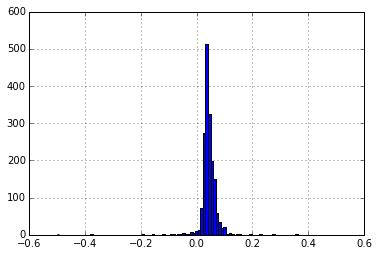

In [187]:
investor_fut_bucket_30360_xirr_orig.hist(bins=np.linspace(-.5,.5,110))

In [197]:
(investor_fut_bucket_30360_xirr_orig[investor_fut_bucket_30360_xirr_orig<0]*100).sort(inplace=False)

fk_user
10109     -37.459966
34054     -19.200474
10860     -15.587540
43106     -11.646885
18565      -9.395938
39596      -8.292229
1051       -6.674273
57196      -6.615652
10875      -6.033690
21689      -5.237668
21616      -5.237668
70380      -5.207702
34979      -4.757932
30313      -4.374064
27499      -4.374064
30250      -4.374064
23793      -4.374064
74370      -3.311351
73515      -3.185728
52551      -2.955957
25480      -2.583975
30245      -2.283771
138        -2.171029
20702      -1.932459
45815      -1.900109
75380      -1.867716
19633      -1.668579
6122       -1.646010
16137      -1.308895
55239      -0.931836
1835       -0.928396
23775      -0.903602
73709      -0.681998
73537      -0.378624
670        -0.031558
18621      -0.016670
dtype: float64

In [205]:
inv_count,inv_bin=np.histogram(investor_fut_bucket_30360_xirr_orig,bins=np.linspace(-.5,.5,101))


In [240]:
cashflows_act_investor[cashflows_act_investor.id_loan==1545]

,date,fk_user_investor,id_loan,payment,dcf,rating_base,rating_switch,payback_state
139859,2015-04-30,34180,1545,13.14,-0.079452,E,3,payback_received
164594,2015-04-30,34180,1545,5000.00,-0.079452,E,3,payback_received
192195,2015-04-07,34180,1545,-5000.00,-0.016438,E,3,payback_received


In [207]:
inv_hist=pd.DataFrame({'bin':inv_bin[:-1],'count':inv_count})

In [208]:
inv_hist.to_clipboard()

In [43]:
%matplotlib inline

In [154]:
loans_fut_bucket_30360_xirr_orig*100

rating_switch
1                2.446569
2                3.991386
3                3.453717
dtype: float64

In [165]:
loans_fut_bucket_30360_xirr_orig*100 

rating_switch
1                2.915440
2                4.099140
3                3.495064
dtype: float64

In [47]:
z1=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete']

xirr(z1.payment, z1.dcf)

0.03470183916784976

In [42]:
loans_fut_bucket_30360_xirr_groups*100

rating_switch  rating_base
1              A              2.164635
               B             -0.289620
               C              2.843701
               D              4.380164
               E              7.495481
2              A              2.336687
               B              3.229219
               C              4.145394
               D              5.631069
               E              7.443198
3              A              2.390730
               B              2.876238
               C              3.830051
               D              4.275146
               E              4.906416
dtype: float64

In [43]:
loans_fut_bucket_30360_xirr_groups.to_clipboard()

In [308]:
loans_fut_bucket_30360_xirr_groups*100

rating_switch  rating_base
1              A              1.643829
               B             -0.131926
               C              2.983228
               D              4.437063
               E              7.266957
2              A              1.954274
               B              2.373271
               C              4.145764
               D              5.446206
               E              7.389547
3              A              2.368428
               B              2.950076
               C              3.790125
               D              3.940688
               E              4.880346
dtype: float64

In [167]:
loans_fut_xirr_groups=cashflows_fut[cashflows_fut.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))

In [246]:
loans_fut_xirr_groups*100

rating_switch  rating_base
1              A               2.318630
               B               2.276984
               C               3.590574
               D               5.797576
               E               7.664678
2              A               2.533089
               B               3.506267
               C               6.085838
               D               7.710767
               E               7.674173
3              A             -15.986781
               B             -15.818247
               C             -14.123845
               D             -11.749378
               E             -12.484912
dtype: float64

In [309]:
(loans_fut_bucket_xirr_groups*100)

rating_switch  rating_base
1              A              1.643829
               B             -0.131926
               C              2.983228
               D              4.437063
               E              7.266957
2              A              1.954274
               B              2.373271
               C              4.145764
               D              5.446206
               E              7.389547
3              A              2.368428
               B              2.950076
               C              3.790125
               D              3.940688
               E              4.880346
dtype: float64

In [168]:
loans_fut_bucket_xirr_groups=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))
(loans_fut_bucket_xirr_groups*100)

rating_switch  rating_base
1              A              2.317944
               B             -0.195389
               C              3.016421
               D              8.264013
               E              7.614183
2              A              2.525294
               B              3.289584
               C              4.318376
               D              5.665452
               E              7.526119
3              A              2.410894
               B              2.911874
               C              3.853142
               D              4.340949
               E              5.067028
dtype: float64

In [154]:
loans_fut_xirr=pd.DataFrame(loans_fut_xirr,columns=['irr'])
loans_fut_xirr_pb=loans_fut_xirr.merge(loans[['id_loan','payback_state']],left_index=True,right_on='id_loan',how='left')
loans_fut_xirr_pb.set_index('id_loan', inplace=True)

In [153]:
loans_fut_xirr1.head()

,irr,id_loan,payback_state
6,0.051250,7,payback
0,0.025000,9,payback
8,0.052125,10,payback
4,0.023063,12,payback
3,0.027797,13,payback


In [89]:
loans_fut_xirr[loans_fut_xirr>.2]


id_loan
51          1.550209
65          2.082980
71          1.026548
92          0.913007
98          0.921890
232         2.715411
253         2.530222
270         3.796371
304         0.236168
334         5.211220
349         2.898589
354         4.808944
366         3.689217
498         6.032595
507         5.509628
625         0.961159
860        68.781251
dtype: float64

In [103]:
loans_fut_xirr[loans_fut_xirr<-.2]

id_loan
27        -0.871503
76        -0.959543
449       -0.470978
dtype: float64

In [136]:
(loans_fut_xirr[loans_fut_xirr<.2]*100).hist(bins=100)

In [121]:
loans.state.value_counts()

payback                    1669
payout_pending                8
payout_approval_pending       2
dtype: int64

In [96]:
payment_plans[payment_plans.fk_loan==65]

,dwh_country_id,fk_loan_payment_plan,fk_user,fk_loan_request,fk_loan,country_name,currency_code,loan_request_creation_date,interval,payment_amount,interest_amount,principal_amount,interval_payback_date,next_interval_payback_date,initial_principal_amount,sum_interval_interest_amount,residual_interest_amount,residual_principal_amount,eur_payment_amount,recovery
2067,1,63,5527,3533,65,Germany,EUR,2014-01-29,1,549.32,92.0000,457.3200,2014-04-01,2014-04-17,12000.0000,92.0000,517.9653,11542.6800,549.32,0.2613
2068,1,63,5527,3533,65,Germany,EUR,2014-01-29,2,0.00,0.0000,0.0000,2014-04-17,2014-05-15,11542.6800,92.0000,517.9653,11542.6800,0.00,0.2613
2069,1,63,5527,3533,65,Germany,EUR,2014-01-29,3,549.32,129.7910,419.5290,2014-05-15,2014-06-15,11542.6800,221.7910,388.1743,11123.1510,549.32,0.2613
2070,1,63,5527,3533,65,Germany,EUR,2014-01-29,4,549.32,85.2775,464.0425,2014-06-15,2014-07-15,11123.1510,307.0685,302.8968,10659.1085,549.32,0.2613
2071,1,63,5527,3533,65,Germany,EUR,2014-01-29,5,549.32,81.7198,467.6002,2014-07-15,2014-08-15,10659.1085,388.7883,221.1770,10191.5083,549.32,0.2613
2072,1,63,5527,3533,65,Germany,EUR,2014-01-29,6,549.32,78.1349,471.1851,2014-08-15,2014-09-15,10191.5083,466.9232,143.0421,9720.3232,549.32,0.2613
2073,1,63,5527,3533,65,Germany,EUR,2014-01-29,7,549.32,74.5225,474.7975,2014-09-15,2014-10-14,9720.3232,541.4457,68.5196,9245.5257,549.32,0.2613
2074,1,63,5527,3533,65,Germany,EUR,2014-01-29,8,9314.05,68.5196,9245.5257,2014-10-14,2199-01-01,9245.5257,609.9653,0.0000,0.0000,9314.05,0.2613


In [122]:
np.histogram(payment_plans.payment_amount,bins=[0,1,5,10,20,100,500,1000])

(array([   70,   328,   263,   504, 17098, 60279,  7554]),
 array([   0,    1,    5,   10,   20,  100,  500, 1000]))

In [127]:
np.histogram(payment_plans.payment_amount[payment_plans.interval==0],bins=[0,1,5,10,20,100,500,1000])

(array([ 69, 328, 263, 383, 705,  60,   0]),
 array([   0,    1,    5,   10,   20,  100,  500, 1000]))

In [164]:
resid=payment_plans_idx.loc[idx[:,:,payment_plans_idx.index.get_level_values(2)<'2015-03-24']\
                        ,'residual_principal_amount'].groupby(level=(0,1)).nth(-1)
cashflows=payment_plans_idx.loc[idx[:,:,payment_plans_idx.index.get_level_values(2)<'2015-03-24'],'payment_amount']
cashflows1=cashflows.append([-loan_orig.principal_amount,resid])
cashflows2=pd.DataFrame(cashflows1)
cashflows2['dcf']=(np.datetime64('2015-03-24','D')-np.array(cashflows2.index.get_level_values(2).to_datetime(),dtype='datetime64[D]'))/np.timedelta64(1,'D')/365

In [255]:
cashflows=pd.DataFrame(payment_plans_pd.loc[~(payment_plans_pd.fk_loan.isin(miss_loans)),['fk_loan','interval_payback_date','e_tot']])
cashflows.interval_payback_date=np.array(cashflows.interval_payback_date,'datetime64[D]')
cashflows.e_tot*=(1-.01)
loans_orig=loans.loc[~(payment_plans_pd.fk_loan.isin(miss_loans)),['id_loan','originated_since','principal_amount']]
loans_orig.principal_amount=-loans_orig.principal_amount
loans_orig['originated_since_date']=np.array(loans_orig['originated_since'],'datetime64[D]')

cashflows1=cashflows.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date','e_tot':'payment'})


In [169]:
cashflows.head()

,fk_loan,interval_payback_date,e_tot
0,7,2014-01-01,0.630000
1,7,2014-02-01,44.000624
2,7,2014-03-01,43.810256
3,7,2014-04-01,43.620712
4,7,2014-05-01,43.431988


In [256]:
principal_payments=loans_orig[['id_loan','originated_since_date' ,'principal_amount']].\
    rename(columns={'originated_since_date':'date' ,'principal_amount':'payment'})
cashflows2=cashflows1.append(principal_payments,ignore_index=True)
cashflows2["dcf"]=(np.datetime64('2015-03-24','D')  -cashflows2["date"].values)/np.timedelta64(1,'D')/365

In [257]:
cashflows2["dcf"]=(np.datetime64('2015-03-24','D')  -cashflows2["date"].values)/np.timedelta64(1,'D')/365

In [ ]:
cashflows2[cashflows2.id_loan==85]

In [258]:
cashflows2[cashflows2.id_loan==85]

,id_loan,date,payment,dcf
43329,966,2015-02-01,9.098100,0.139726
43330,966,2015-03-01,81.251575,0.063014
43331,966,2015-04-01,80.553800,-0.021918
43332,966,2015-05-01,79.860454,-0.104110
43333,966,2015-06-01,79.171508,-0.189041
43334,966,2015-07-01,78.486937,-0.271233
43335,966,2015-08-01,77.806712,-0.356164
43336,966,2015-09-01,77.130806,-0.441096
43337,966,2015-10-01,76.459193,-0.523288
43338,966,2015-11-01,75.791845,-0.608219


In [286]:
actual_payments[actual_payments.fk_loan==966]

,dwh_country_id,fk_user_borrower,fk_loan,loan_nr,iso_date,payment_amount,payment_amount_cum,principal_amount,interest_amount,sum_interval_interest_amount,...,principal_amount_cum,initial_principal_amount,residual_principal_amount,expected_amount_month,expected_amount_cum,actual_amount_month,actual_amount_cum,in_arrears_flag,in_arrears_since,in_arrears_since_days
5343,1,73957,966,140346852,2015-02-28,9.19,9.19,0.000,9.1867,9.1867,...,0.000,3000,3000.000,9.19,9.19,9.19,9.19,0,NaN,NaN
5344,1,73957,966,140346852,2015-03-31,71.69,80.88,54.465,17.2250,26.4117,...,54.465,3000,2945.535,71.69,80.88,71.69,80.88,0,NaN,NaN


In [186]:
xirr(cashflows2.loc[cashflows2.id_loan==500,'payment'],cashflows2.loc[cashflows2.id_loan==500,'dcf'])*100

5.4735134310179845

In [100]:
miss_loans=set(loans.id_loan) ^ set(payment_plans.fk_loan) # symmetric difference

In [259]:
loans_xirr=cashflows2.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [215]:
mth3_loans=loans_orig.id_loan[loans_orig.originated_since_date<np.datetime64('2015-01-22')]

In [252]:
payment_plans_pd[payment_plans_pd.fk_loan==966].to_clipboard()

In [260]:

f=plt.figure(1)
f.clf()
(loans_xirr*100).hist()

In [207]:
loans[loans.id_loan==966].T

,991
dwh_country_id,1
id_loan,966
fk_loan_request,55818
fk_user,73957
fk_ranking,13143
country_name,Germany
currency_code,EUR
loan_request_creation_date,2015-01-07 00:00:00
user_age,55
loan_nr,140346852


In [251]:
(loans_xirr.loc[mth3_loans]*100).hist()

In [253]:
loans_xirr.loc[966]

0.03870272564140468

In [254]:
loans_orig[loans_orig.id_loan==966]

,id_loan,originated_since,principal_amount,originated_since_date
991,966,2015-01-15 15:27:19,-3000,2015-01-15


In [203]:
cashflows2[cashflows2.id_loan==966].sort('date').to_clipboard()

In [103]:
no0=set(payment_plans.fk_loan.unique()) - set( pp1.fk_loan.unique()) # checking if each loan has interval 0 
no0

{16,
 21,
 38,
 40,
 63,
 64,
 65,
 68,
 73,
 94,
 195,
 200,
 202,
 203,
 204,
 205,
 234,
 245,
 251,
 253,
 256,
 257,
 258,
 271,
 320,
 435,
 704,
 709,
 718,
 719,
 721,
 730,
 784,
 978,
 1502,
 1602,
 1618,
 1625,
 1628,
 1631,
 1645,
 1647,
 1654,
 1690,
 1703,
 1728,
 1730,
 1754,
 1756}

In [107]:
loan_plan_nar=payment_plans_idx.loc[payment_plans_idx.interval!=0,['interest_amount','initial_principal_amount']].groupby(level=(0,1)).sum()